Epoch 1/70
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.1430 - loss: 10.8846 - val_accuracy: 0.2422 - val_loss: 1.9797
Epoch 2/70
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2256 - loss: 2.1925 - val_accuracy: 0.3204 - val_loss: 1.7930
Epoch 3/70
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2724 - loss: 1.8886 - val_accuracy: 0.3807 - val_loss: 1.6855
Epoch 4/70
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3467 - loss: 1.7345 - val_accuracy: 0.4135 - val_loss: 1.5996
Epoch 5/70
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4106 - loss: 1.5855 - val_accuracy: 0.4445 - val_loss: 1.5462
Epoch 6/70
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.4456 - loss: 1.5051 - val_accuracy: 0.4690 - val_loss: 1.4779
Epoch 7/70
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.4767 - loss: 1.4248 - val_accuracy: 0.5197 - val_loss: 1.3698
Epoch 8/70
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5118 - loss: 1.3266 - val_acc

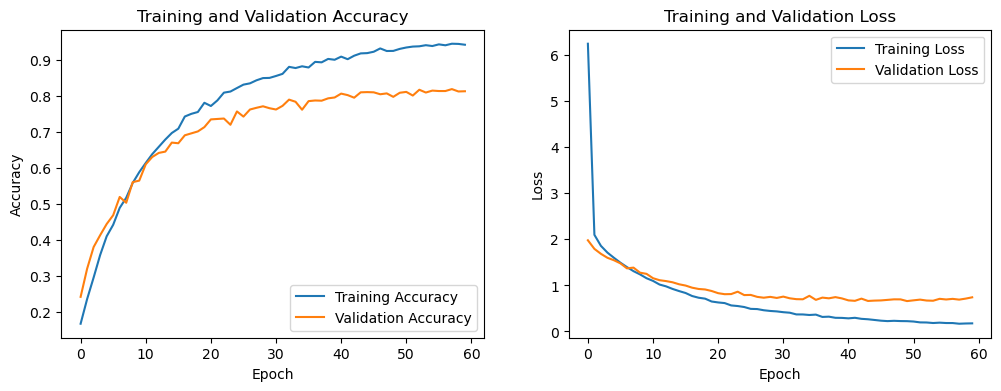

Test Accuracy: 80.91%


In [14]:
import joblib
import os
import numpy as np
import librosa
import random
from tensorflow.keras.layers import Conv1D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import kagglehub

dataset_path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

def extract_mel_spectrogram(input_data, sr=22050, n_mels=40, max_pad_len=100, from_file=True):
    if from_file:
        y, sr = librosa.load(input_data, sr=sr, res_type='kaiser_fast')
    else:
        y = input_data  
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    if mel_db.shape[1] < max_pad_len:
        pad_width = max_pad_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_pad_len]
    return mel_db.T

def random_pitch_shift(y, sr, n_steps_range=(-3, 3)):
    n_steps = random.uniform(*n_steps_range)
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def stretch_waveform(y, sr=22050, stretch_range=(0.8, 1.2)):
    rate = random.uniform(*stretch_range)
    stretched_y = librosa.resample(y, orig_sr=sr, target_sr=int(sr * rate))
    return stretched_y

def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    return y + noise_factor * noise

def shift_time(y, shift_max=5, shift_direction='both'):
    shift = np.random.randint(-shift_max, shift_max)
    if shift_direction == 'right':
        shift = abs(shift)
    elif shift_direction == 'left':
        shift = -abs(shift)
    y_shifted = np.roll(y, shift)
    return y_shifted

mfcc_features = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith('.wav') and file.startswith('03-01'):
            try:
                file_path = os.path.join(root, file)
                mel_spect = extract_mel_spectrogram(file_path, from_file=True)
                file_class = int(file[7:8]) - 1  
                mfcc_features.append((mel_spect, file_class))

                y, sr = librosa.load(file_path, sr=22050, res_type='kaiser_fast')
                
                random_number = random.randint(1, 4)
                if random_number == 1:
                    noisy_y = add_noise(y)
                    noisy_mel_spect = extract_mel_spectrogram(noisy_y, from_file=False)
                    mfcc_features.append((noisy_mel_spect, file_class))

                    shifted_y = shift_time(y)
                    shifted_mel_spect = extract_mel_spectrogram(shifted_y, from_file=False) 

                    mfcc_features.append((shifted_mel_spect, file_class))
                    pitch_shifted_y = random_pitch_shift(y, sr)
                    pitch_shifted_mel_spect = extract_mel_spectrogram(pitch_shifted_y, from_file=False)
                    mfcc_features.append((pitch_shifted_mel_spect, file_class))

                    stretched_y = stretch_waveform(y)
                    stretched_mel_spect = extract_mel_spectrogram(stretched_y, from_file=False)
                    mfcc_features.append((stretched_mel_spect, file_class))

            except ValueError as err:
                print(f"Error processing file {file}: {err}")

                
def pad_or_truncate(spectrogram, max_length=100):
    if spectrogram.shape[0] < max_length:
        pad_width = max_length - spectrogram.shape[0]
        return np.pad(spectrogram, ((0, pad_width), (0, 0)), mode='constant')
    else:
        return spectrogram[:max_length, :]

x = [pad_or_truncate(feature) for feature, label in mfcc_features]
y = [label for feature, label in mfcc_features]

x = np.array(x, dtype=np.float32)

mlb = MultiLabelBinarizer(classes=range(8))
y = mlb.fit_transform([[label] for label in y])

x = np.expand_dims(x, -1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True)

model = Sequential()
model.add(Conv1D(64, 5, padding='same', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv1D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=70, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")